# Seurat processing + surface marker expression

In [ ]:
library(Seurat)
library(SeuratDisk)
library(tidyverse)
library(SeuratWrappers)
library(monocle3)
library(future)
plan(multicore)
options(future.globals.maxSize = 50 * 1000 * 1024^2)
availableCores()

## Load raw data processed using Scanpy

In [ ]:
adata <- LoadH5Seurat("./081522other_raw_data.h5seurat")

## Remove sample 9 (Patient 985) from dataset due to low transcript counts and sequencing depth

In [ ]:
adata <- subset(adata, subset= batch != "sample9")
adata@meta.data["nCount_RNA"] = adata@meta.data["n_counts"]
adata@meta.data["nFeature_RNA"] = adata@meta.data["n_genes"]

## Plots of quality control variables

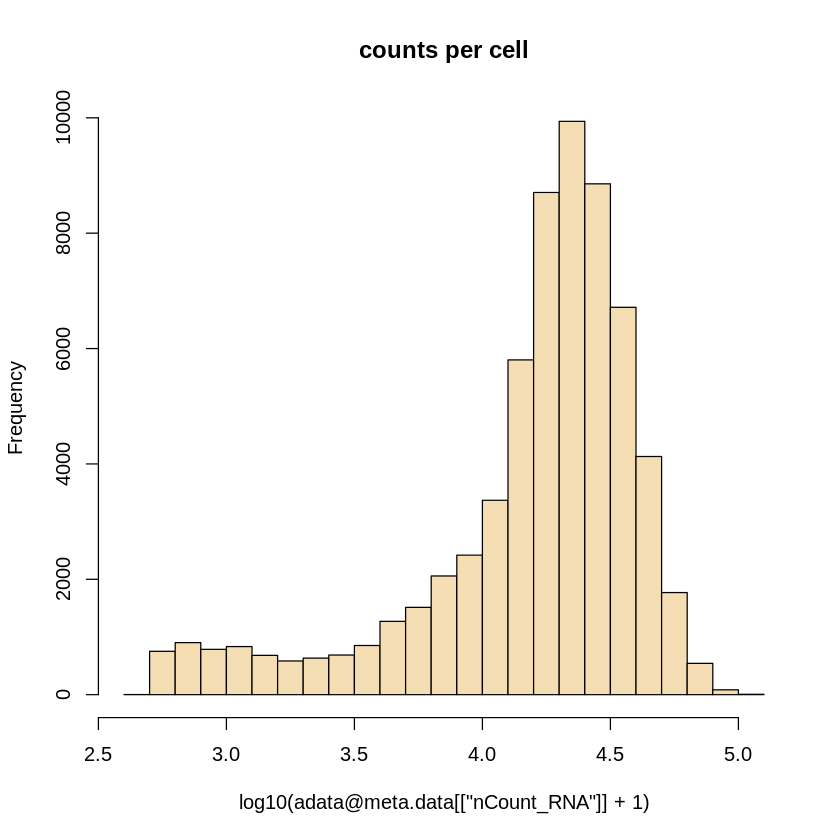

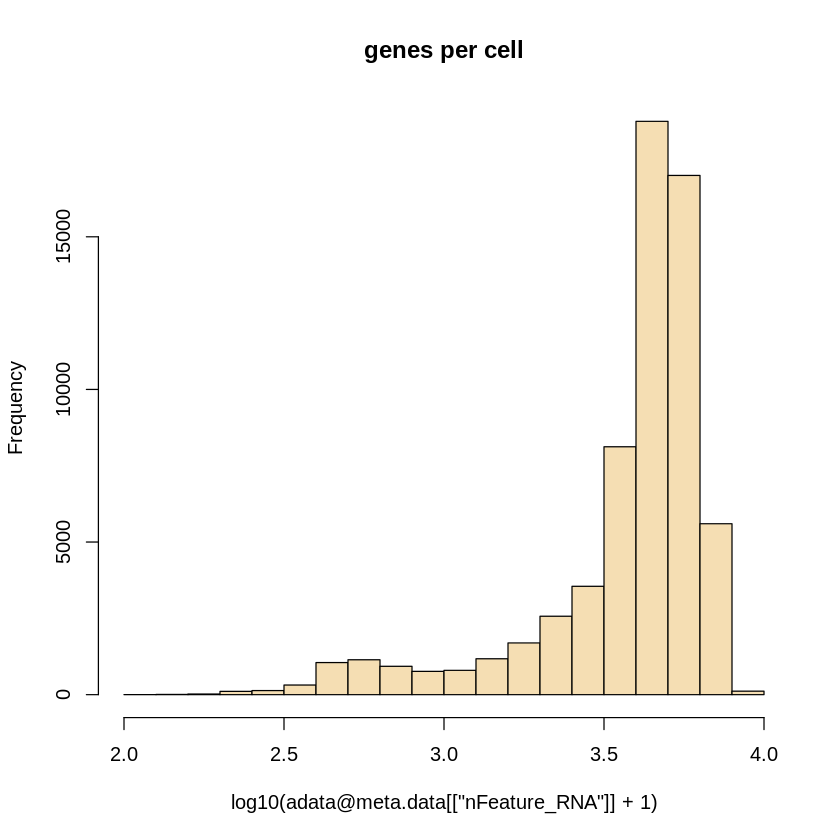

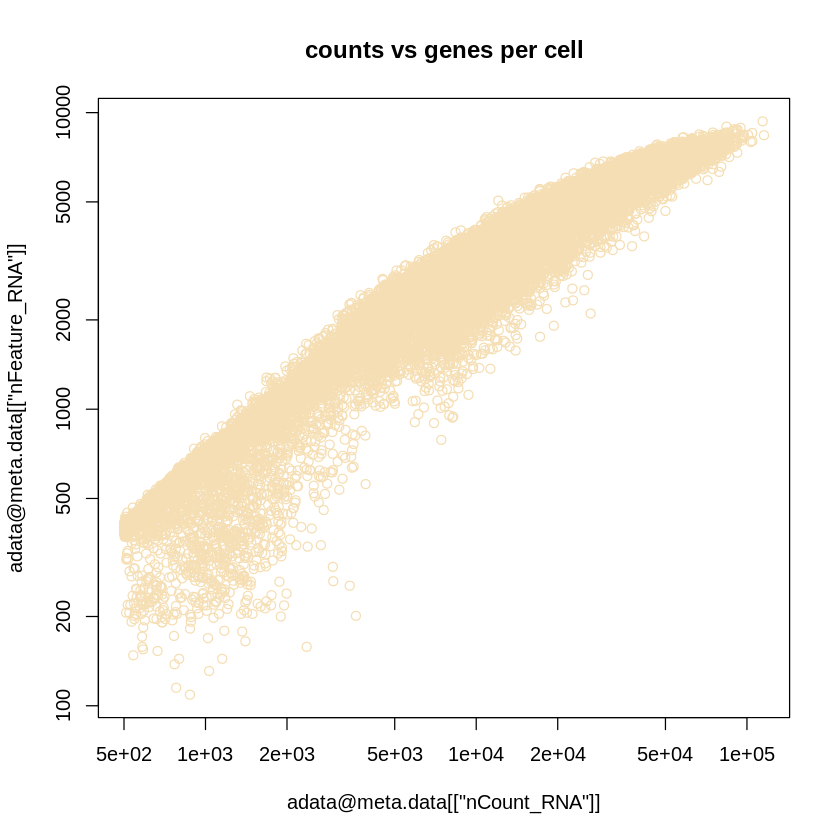

In [4]:
hist(log10(adata@meta.data[["nCount_RNA"]]+1),main='counts per cell',col='dodgerblue')
hist(log10(adata@meta.data[["nFeature_RNA"]]+1), main='genes per cell', col='dodgerblue')
plot(adata@meta.data[["nCount_RNA"]], adata@meta.data[["nFeature_RNA"]], log='xy', col='dodgerblue')
title('counts vs genes per cell')

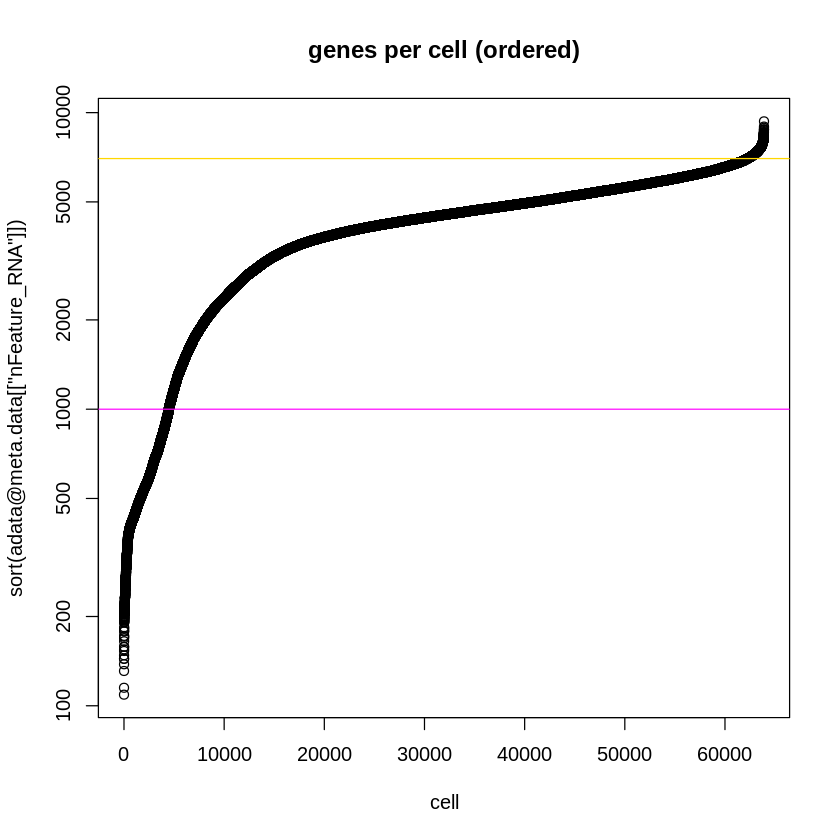

In [16]:
#  set upper and lower thresholds for genes per cell:
MIN_GENES_PER_CELL <- 1000  ## user-defined setting
MAX_GENES_PER_CELL <- 7000  ## user-defined setting

# now replot with the thresholds being shown:
plot(sort(adata@meta.data[["nFeature_RNA"]]), xlab='cell', log='y', main='genes per cell (ordered)')
abline(h=MIN_GENES_PER_CELL, col='magenta')  # lower threshold
abline(h=MAX_GENES_PER_CELL, col='gold') # upper threshold

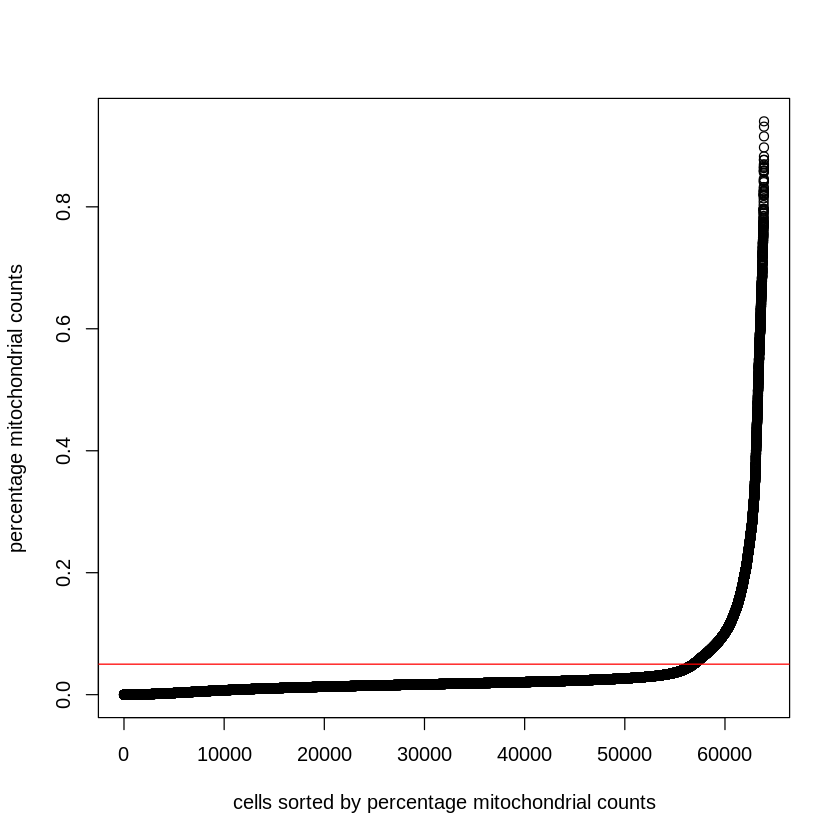

In [10]:
MAX_FRAC_MITO <- 0.05
plot(sort(adata@meta.data[["mt_frac"]]), 
     xlab = "cells sorted by percentage mitochondrial counts", 
     ylab = "percentage mitochondrial counts")
abline(h=MAX_FRAC_MITO, col='red')

## Subset dataset based on QC metrics

In [5]:
adata <- subset(adata, subset = nFeature_RNA > 1000 & nFeature_RNA < 7000 & mt_frac < 0.05)

## Run dataset integration using scTransform and Seurat integration to find clusters

In [7]:
adata.list <- SplitObject(adata, split.by = "batch")

In [8]:
names(adata.list)

[1] "sample1"  "sample2"  "sample3"  "sample4"  "sample5"  "sample6"  "sample7" 
[8] "sample8"  "sample10"

In [ ]:
adata.list <- SplitObject(adata, split.by = "batch")
for (i in seq_along(adata.list)) {
   adata.list[[i]] <- SCTransform(adata.list[[i]], method = "glmGamPoi", vars.to.regress = c("mt_frac", "passage"), verbose = T)
}
features <- SelectIntegrationFeatures(adata.list)

adata.anchors <- FindIntegrationAnchors(object.list = adata.list, anchor.features = features)
adata.integrated <- IntegrateData(anchorset = adata.anchors)

DefaultAssay(adata.integrated) <- "integrated"

# Run the standard workflow for visualization and clustering
adata.integrated <- ScaleData(adata.integrated, verbose = FALSE)
adata.integrated <- RunPCA(adata.integrated, npcs = 30, verbose = T)
adata.integrated <- RunUMAP(adata.integrated, reduction = "pca", dims = 1:30)
adata.integrated <- FindNeighbors(adata.integrated, reduction = "pca", dims = 1:30)
adata.integrated <- FindClusters(adata.integrated, resolution = 0.5)
options(repr.plot.width=30, repr.plot.height=7)
DimPlot(adata.integrated, reduction = "umap", group.by = c("seurat_clusters", "type", "batch"))
saveRDS(adata.integrated, "./seurat_final.rds")

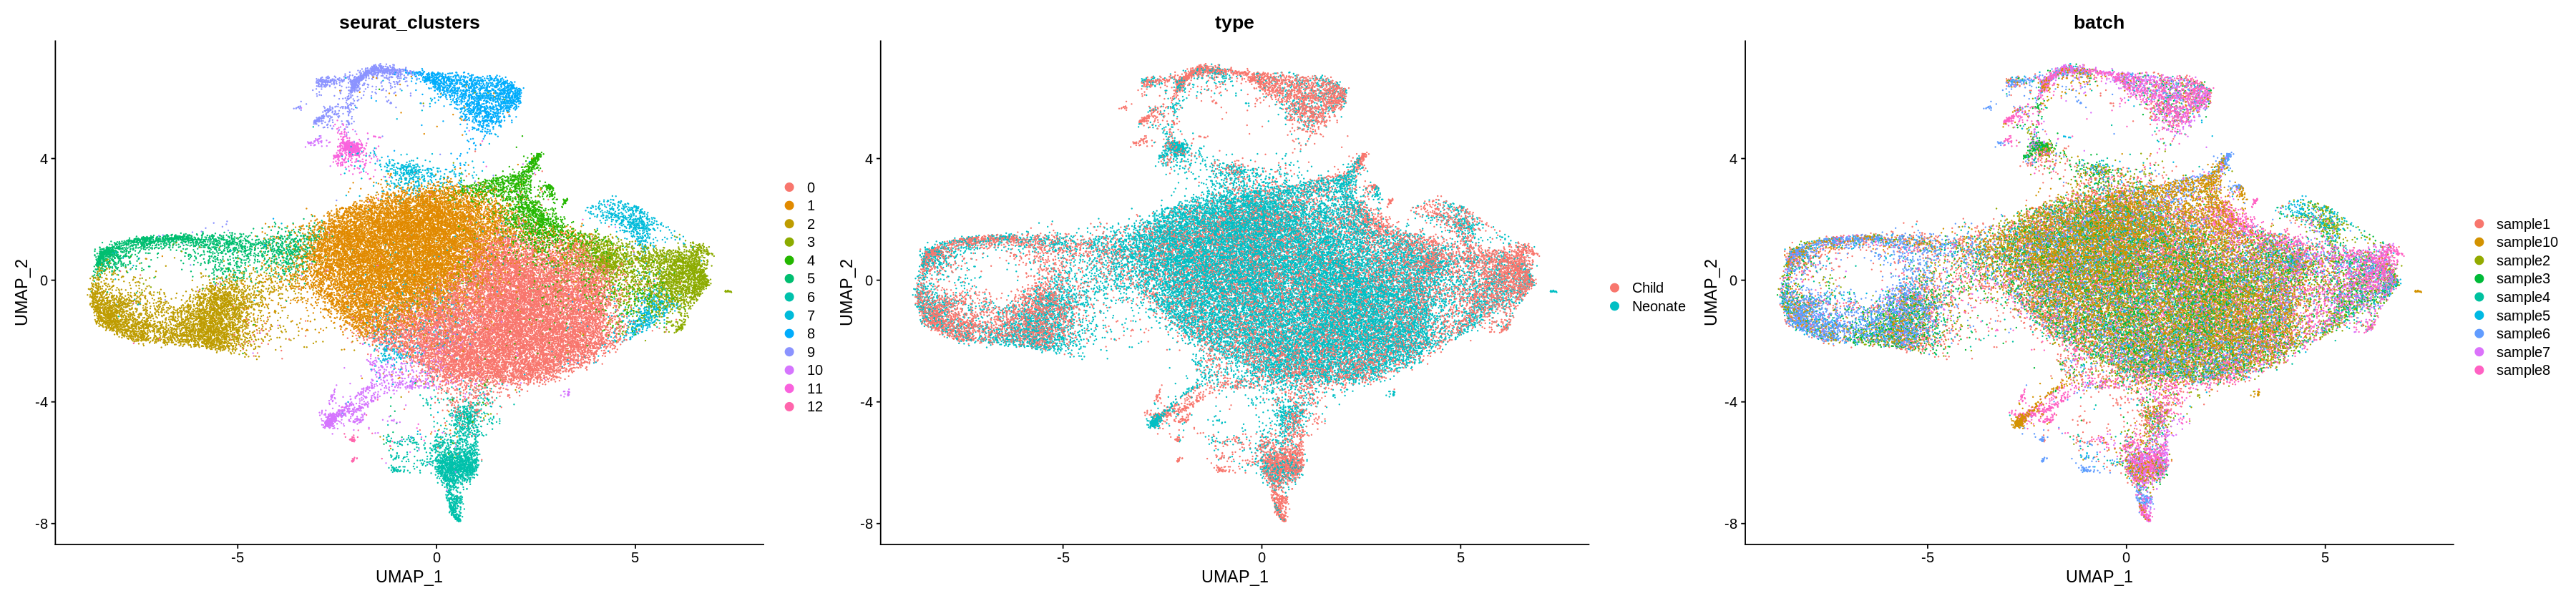

In [4]:
options(repr.plot.width=30, repr.plot.height=7)
DimPlot(adata.integrated, reduction = "umap", group.by = c("seurat_clusters", "type", "batch"))

## Use original RNA assay for downstream analysis

In [5]:
DefaultAssay(adata.integrated) <- "RNA"

In [6]:
adata.integrated <- NormalizeData(adata.integrated) %>% FindVariableFeatures()
adata.integrated <- ScaleData(adata.integrated, verbose = FALSE)

## DE Analysis

In [14]:
library(methods)
library(Seurat)

# adata.integrated <- readRDS("./seurat_final.rds")
clust.de.markers <- FindAllMarkers(adata.integrated)
rm(adata.integrated)
save(clust.de.markers, file="seurat_de.RData")

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Warning message:
"No DE genes identified"
Warning message:
"The following tests were not performed: "
Warning message:
"When testing 0 versus all:
	vector memory exhausted (limit reached?)"
Warning message:
"When testing 1 versus all:
	error in evaluating the argument 'x' in selecting a method for function 'rowSums': vector memory exhausted (limit reached?)"
Warning message:
"When testing 2 versus all:
	error in evaluating the argument 'x' in selecting a method for function 'rowSums': vector memory exhausted (limit reached?)"
Warning message:
"When testing 3 versus all:
	error in evaluating the argument 'x' in selecting a method for function 'rowSums': vector memory exhausted (limit reache

#### Write upregulated genes from each cluster to a file

In [37]:
genes_up <- clust.de.markers[(clust.de.markers$avg_log2FC > 0),]
genes_up <- genes_up[with(genes_up, order(-avg_log2FC)),]

In [60]:
write.csv(t(plyr::ldply(split(genes_up$gene, genes_up$cluster), rbind)), "./seurat_top_v2.csv", row.names=F)

# Surface protein expression analysis

#### Read surface protein dataset: https://wlab.ethz.ch/cspa/data/S2_File.xlsx

In [44]:
surf_prot <- read_excel("./CSR_surface_proteins.xlsx", sheet = "Table A")
surf_prot <- surf_prot[(surf_prot$organism == "Human") & (surf_prot$`CSPA category` == "1 - high confidence"),]
dim(surf_prot)

[1] 1039   14

#### Filter for CD proteins

In [45]:
CD_prot <- surf_prot[surf_prot$CD != "no",]

#### Find conserved gene markers (i.e. genes that are expressed in all samples within the same cell cluster)

In [ ]:
clust_markers = list()
for (i in levels(adata.integrated$seurat_clusters)){
    clust_markers[[i]] = FindConservedMarkers(adata.integrated, ident.1 = i, grouping.var = "batch")
}

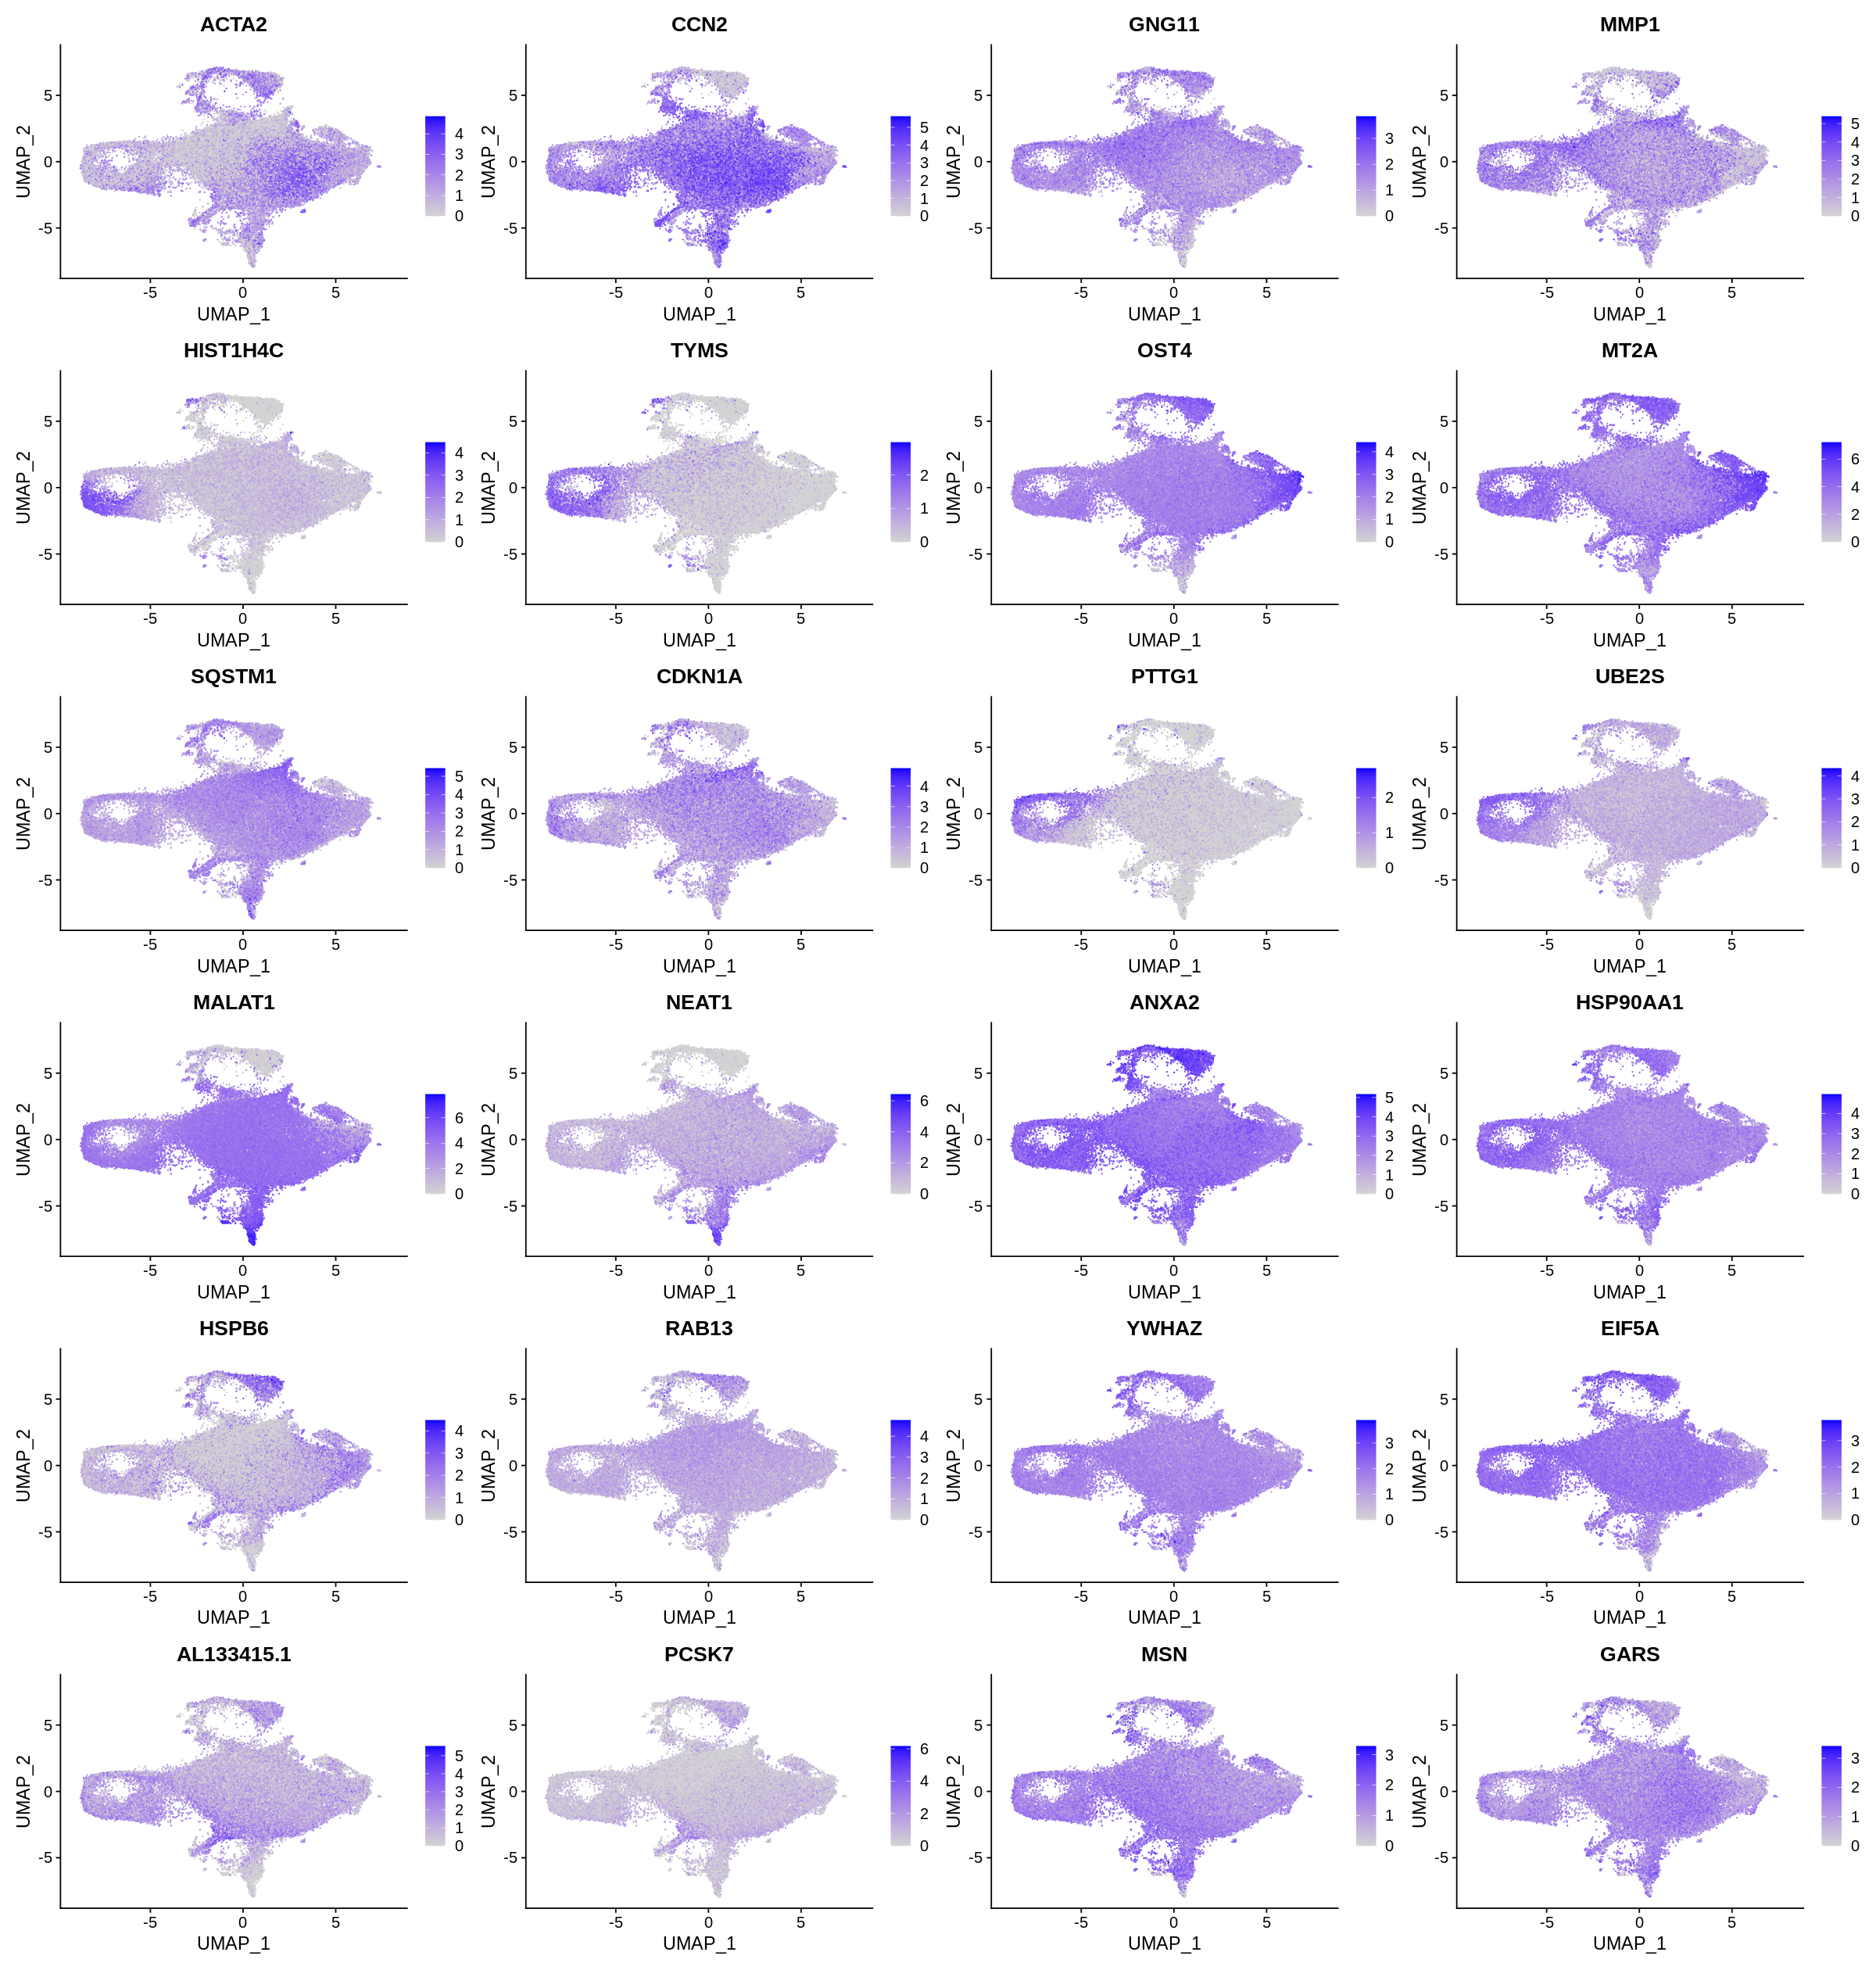

In [15]:
genes = c()
for (i in names(clust_markers)) {
    clust_markers[[i]]$log2FC_avg <- rowMeans(clust_markers[[i]][,colnames(clust_markers[[i]])[grep("avg_log2FC", colnames(clust_markers[[i]]))]])
    clust_markers[[i]] %>% top_n(n = 2, wt = log2FC_avg) -> top
    genes = c(genes, rownames(top))
}
options(repr.plot.width=20, repr.plot.height=7*length(genes)/8)
FeaturePlot(adata.integrated, features = unique(genes))

#### Find upregulated conserved DE genes

In [39]:
genes = list()
for (i in names(clust_markers)) {
    genes_up <- clust_markers[[i]][clust_markers[[i]]$log2FC_avg > 0,]
#     genes_up %>% top_n(n = 100, wt = log2FC_avg) -> top
    genes[[i]] = rownames(genes_up)
}

In [40]:
genes
write.csv(t(plyr::ldply(genes, rbind)), "./seurat_top_cons.csv", row.names=F)

$`0`
[1] "SPARC"  "STC2"   "ACTA2"  "CCN2"   "ANKRD1"

$`1`
[1] "LMNA"  "GNG11" "MMP1" 

$`2`
 [1] "CLSPN"    "RRM2"     "UBE2C"    "FEN1"     "HIST1H4C" "TYMS"    
 [7] "CDC20"    "PCNA"     "PCLAF"    "HELLS"    "DEK"      "TK1"     
[13] "H2AFZ"    "STMN1"    "PRC1"     "DNMT1"    "DUT"      "H2AFX"   
[19] "RANBP1"   "HMGB1"    "HNRNPF"   "PTMA"     "TEX30"    "TUBA1B"  
[25] "DTYMK"    "HMGN2"    "TFDP1"    "ALYREF"   "SIVA1"    "CKS2"    
[31] "SRSF7"    "SLC29A1"  "YWHAH"    "TUBB"     "PTTG1"    "RPL39L"  
[37] "PPM1G"    "SLC25A5"  "KPNA2"    "UBE2S"    "PTGES3"   "FBL"     
[43] "TUBB4B"   "CENPX"    "CACYBP"   "KPNB1"    "TUBG1"    "BUB3"    
[49] "SNRPD1"   "RAN"      "SNRPB"    "PA2G4"    "TOMM40"   "CMC2"    
[55] "RNPS1"    "PGP"      "POP7"     "PSMG1"    "SRSF3"   

$`3`
 [1] "RNASEK"   "OST4"     "MIF"      "NME2"     "RPS26"    "MT2A"    
 [7] "UQCR11"   "NDUFA11"  "SERF2"    "UQCR10"   "SEC61G"   "TOMM7"   
[13] "COMMD6"   "RPL11"    "ATP6V0E1" "SH3BGRL3" "PPDPF"    "ATP6V0C" 
[19] "PDLIM2"   "SELENOW"  "FTH1"     "SELENOM" 

$`4`
 [1] "SQSTM1" "FTH1"   "TIMP1"  "PLIN2"  "SAT1"   "FTL"    "CEBPB"  "BTG1"  
 [9] "CDKN1A" "TGIF1"  "DDIT4"  "PNRC1"  "NFKBIA"

$`5`
 [1] "KIF20A"    "CCNB1"     "CDKN3"     "CDCA3"     "PTTG1"     "PLK1"     
 [7] "DLGAP5"    "PRC1"      "CENPF"     "CDC20"     "ANLN"      "STMN1"    
[13] "UBE2S"     "BIRC5"     "CCNB2"     "DEPDC1"    "H2AFZ"     "MKI67"    
[19] "HMGB1"     "CEP55"     "CENPW"     "PCLAF"     "HMGN2"     "TK1"      
[25] "TACC3"     "TPX2"      "UBE2C"     "TUBA1B"    "PTMA"      "HNRNPA2B1"
[31] "HNRNPA1"   "TYMS"      "TUBB4B"    "HMGA1"     "CKS1B"     "KPNA2"    
[37] "TUBA1C"    "SMC4"      "PHF19"     "H2AFV"     "H3F3B"     "RANBP1"   
[43] "DTYMK"     "ANP32B"    "SFPQ"      "DEK"       "NPM1"      "RAN"      
[49] "HSPD1"     "SET"       "PTGES3"    "H2AFX"     "JPT1"      "ANP32E"   
[55] "TUBB"      "SMS"       "TMPO"      "CDK1"      "SNRPB"     "EIF5A"    
[61] "RPL39L"    "ALYREF"    "HNRNPA3"   "HNRNPD"    "SRSF3"     "SLC25A5"  
[67] "CCT5"      "LSM5"      "SNRPG"     "HNRNPU"    "CENPN"     "CKS2"     
[73] "PSIP1"     "SNRPA"     "NUDT1"     "SRSF2"     "LMNA"      "HNRNPK"   
[79] "DAZAP1"    "XRCC6"     "LSM3"      "RUVBL2"   

$`6`
  [1] "SLC4A7"      "DST"         "FN1"         "MACF1"       "ATP13A3"    
  [6] "SLC38A2"     "DCBLD2"      "VCL"         "GLS"         "MEG3"       
 [11] "VCAN"        "MALAT1"      "TRIO"        "ATP2B4"      "DYNC1H1"    
 [16] "NEAT1"       "WSB1"        "LIMA1"       "CACNA2D1"    "SPTBN1"     
 [21] "FBN1"        "AFF4"        "LAMB1"       "VPS13C"      "FAP"        
 [26] "PLOD2"       "ITGA2"       "SF3B1"       "RRBP1"       "ASCC3"      
 [31] "MYOF"        "COL1A2"      "COL3A1"      "ADAM10"      "CD46"       
 [36] "CLTC"        "CDH2"        "IQGAP1"      "LAMC1"       "LNPEP"      
 [41] "ITGAV"       "SLC20A1"     "SPTAN1"      "BIRC6"       "TMEM30A"    
 [46] "LOXL2"       "KIAA1109"    "IL6ST"       "ZFC3H1"      "DDX17"      
 [51] "MYO1B"       "SERPINE1"    "IGF2R"       "NRP1"        "PAPPA"      
 [56] "EDIL3"       "DOCK7"       "FAT1"        "NCKAP1"      "LTBP1"      
 [61] "CEP170"      "NF1"         "HUWE1"       "SPAG9"       "COL6A1"     
 [66] "NOTCH2"      "SACS"        "NFAT5"       "PXDN"        "PRRC2C"     
 [71] "VPS13A"      "MAP4K3"      "NPEPPS"      "TLN1"        "TMEM131"    
 [76] "ZNF638"      "GOLGB1"      "HIF1A"       "ADAM9"       "KDM5B"      
 [81] "SEL1L"       "GTF3C1"      "ASPH"        "KMT2A"       "ABI3BP"     
 [86] "UGGT2"       "ZFYVE16"     "EEA1"        "FNDC3B"      "COPA"       
 [91] "TRIP12"      "COL8A1"      "RECK"        "SMG1"        "SON"        
 [96] "COL4A1"      "AHNAK"       "ITGB1"       "MAP1B"       "MON2"       
[101] "ANKLE2"      "ATP8B1"      "SYNE1"       "FTX"         "APLP2"      
[106] "CRIM1"       "APP"         "ATM"         "PEAK1"       "UBR5"       
[111] "THBS1"       "OSTM1"       "AKAP9"       "UBA6"        "COL5A

#### Overlap with surface protein dataset to find upregulated and conserved surface proteins for cluster 6 cells

In [46]:
genes_up <- clust_markers[["6"]][(clust_markers[["6"]]$log2FC_avg > 0),]
genes_surf <- genes_up[(rownames(genes_up) %in% CD_prot$`ENTREZ gene symbol`),]
head(genes_surf)

sample5_p_val sample5_avg_log2FC sample5_pct.1 sample5_pct.2
ITGA2  8.274599e-37  1.706151           0.877         0.584        
ADAM10 2.444610e-33  1.371064           0.820         0.619        
CD46   4.433464e-48  1.365719           0.910         0.552        
CDH2   2.532456e-43  1.520514           0.934         0.780        
ITGAV  5.044631e-40  1.309110           0.902         0.634        
IL6ST  1.552867e-41  1.233441           0.943         0.830        
       sample5_p_val_adj sample7_p_val sample7_avg_log2FC sample7_pct.1
ITGA2  3.028586e-32      2.689725e-146 2.193821           0.908        
ADAM10 8.947516e-29      1.029985e-150 1.633020           0.919        
CD46   1.622692e-43      4.634820e-155 1.593669           0.942        
CDH2   9.269041e-39      6.043617e-134 1.845384           0.924        
ITGAV  1.846386e-35      8.292290e-164 1.824181           0.948        
IL6ST  5.683650e-37      3.150013e-117 1.461733           0.960        
       sample7_pct.2 sample7_p_val_adj ... sample2_pct.2 sample2_p_val_adj
ITGA2  0.457         9.844661e-142     ... 0.801         2.930733e-93     
ADAM10 0.501         3.769850e-146     ... 0.682         1.976783e-70     
CD46   0.504         1.696390e-150     ... 0.596         6.469769e-69     
CDH2   0.633         2.212024e-129     ... 0.944         2.417778e-68     
ITGAV  0.538         3.035061e-159     ... 0.893         7.263383e-94     
IL6ST  0.754         1.152936e-112     ... 0.878         1.415566e-55     
       sample1_p_val sample1_avg_log2FC sample1_pct.1 sample1_pct.2
ITGA2  5.194284e-121 1.6224060          0.958         0.818        
ADAM10  4.058549e-69 0.8507724          0.835         0.599        
CD46    1.119038e-77 0.8577865          0.899         0.704        
CDH2   3.942400e-126 1.0929473          0.997         0.979        
ITGAV  5.024599e-155 1.5388701          0.983         0.853        
IL6ST   9.680115e-75 0.8471448          0.924         0.837        
       sample1_p_val_adj max_pval     minimump_p_val log2FC_avg
ITGA2  1.901160e-116     7.505449e-13 6.655804e-230  1.626943  
ADAM10  1.485470e-64     1.264475e-05 1.688210e-224  1.237452  
CD46    4.095792e-73     1.219565e-09 2.493998e-224  1.100398  
CDH2   1.442958e-121     1.951029e-11 9.258786e-223  1.242605  
ITGAV  1.839053e-150     6.433182e-20 3.357360e-221  1.471180  
IL6ST   3.543019e-70     1.074306e-08 1.094888e-213  1.104464